# Beiwe Sample Dataset Accelerometer EDA Pt. 1

Summary of tasks: 
- Analyze accelerometer data from publicly available sample Beiwe dataset (Emedom-Nnamdi et al. 2022)
    - Source: https://zenodo.org/records/6471045
        - Description: 
        > As part of the internal test study, data from 6 participants were collected from the start of March 21, 2022 to the end of March 28, 2022. The local time zone of this study is Eastern Standard Time. Each participant was notified to complete a survey at 9am EST on Monday, Thursday, and Saturday of the study week. An additional survey was administered on Tuesday at 5:15pm EST. For each survey, subjects were asked to respond to the prompt "How much time (in hours) do you think you spent at home?".
- Examine data quality and sampling pattern in hourly CSV files from a randomly selected subject (ID: 3si9xdvl) and date (March 26, 2022)
    - Investigate files with fewer number of rows
- Compute sampling rate, on-off patterns ("duty cycle")

In [1]:
%load_ext autoreload
%autoreload 2 


import pyarrow.parquet as pq
import pyarrow as pa
from datetime import timedelta
from collections import defaultdict
from pathlib import Path
import re
import random
import math
import warnings
import logging
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt

In [17]:
# Log of cells run
%history -n

   1:
%load_ext autoreload
%autoreload 2 


import pyarrow.parquet as pq
import pyarrow as pa
from datetime import timedelta
from collections import defaultdict
from pathlib import Path
import re
import random
import math
import warnings
import logging
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
   2:
# Load all 24 hourly dataframes for participant 3si9xdvl on 2022-03-26
base_path = "/n/home01/egraff/sample_imputation/data/raw/3si9xdvl/accelerometer/"
date = "2022-03-26"

# Dictionary to store all dataframes
hourly_dfs = {}

# Load all 24 hours (00 to 23)
for hour in range(24):
    hour_str = f"{hour:02d}"  # Format as 2-digit string with leading zero
    filename = f"{date} {hour_str}_00_00+00_00.csv"
    filepath = base_path + filename
    
    try:
        df = pd.read_csv(filepath)
        hourly_dfs[f"hr_{hour+1}_df"] = df  # hr_1_df through hr_24_df
        print(f"hr_{hour+1}_df ({hour_str}:00)

In [22]:
# Load all 24 hourly dataframes for participant 3si9xdvl on 2022-03-26
base_path = "/n/home01/egraff/sample_imputation/data/raw/3si9xdvl/accelerometer/"
date = "2022-03-26"

# Dictionary to store all dataframes
hourly_dfs = {}

# Load all 24 hours (00 to 23)
for hour in range(24):
    hour_str = f"{hour:02d}"  # Format as 2-digit string with leading zero
    filename = f"{date} {hour_str}_00_00+00_00.csv"
    filepath = base_path + filename
    
    try:
        df = pd.read_csv(filepath)
        hourly_dfs[f"hr_{hour}_df"] = df  # hr_0_df through hr_23_df
        print(f"hr_{hour}_df ({hour_str}:00): {df.shape[0]} rows")
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Also create individual variables for easier access
hr_1_df = hourly_dfs.get("hr_1_df")
hr_2_df = hourly_dfs.get("hr_2_df")
hr_3_df = hourly_dfs.get("hr_3_df")
hr_4_df = hourly_dfs.get("hr_4_df")
hr_5_df = hourly_dfs.get("hr_5_df")
hr_6_df = hourly_dfs.get("hr_6_df")
hr_7_df = hourly_dfs.get("hr_7_df")
hr_8_df = hourly_dfs.get("hr_8_df")
hr_9_df = hourly_dfs.get("hr_9_df")
hr_10_df = hourly_dfs.get("hr_10_df")
hr_11_df = hourly_dfs.get("hr_11_df")
hr_12_df = hourly_dfs.get("hr_12_df")
hr_13_df = hourly_dfs.get("hr_13_df")
hr_14_df = hourly_dfs.get("hr_14_df")
hr_15_df = hourly_dfs.get("hr_15_df")
hr_16_df = hourly_dfs.get("hr_16_df")
hr_17_df = hourly_dfs.get("hr_17_df")
hr_18_df = hourly_dfs.get("hr_18_df")
hr_19_df = hourly_dfs.get("hr_19_df")
hr_20_df = hourly_dfs.get("hr_20_df")
hr_21_df = hourly_dfs.get("hr_21_df")
hr_22_df = hourly_dfs.get("hr_22_df")
hr_23_df = hourly_dfs.get("hr_23_df")
hr_24_df = hourly_dfs.get("hr_24_df")

hr_0_df (00:00): 602 rows
File not found: 2022-03-26 01_00_00+00_00.csv
File not found: 2022-03-26 02_00_00+00_00.csv
File not found: 2022-03-26 03_00_00+00_00.csv
hr_4_df (04:00): 8620 rows
hr_5_df (05:00): 11438 rows
hr_6_df (06:00): 18081 rows
hr_7_df (07:00): 18100 rows
hr_8_df (08:00): 18098 rows
hr_9_df (09:00): 18090 rows
hr_10_df (10:00): 18088 rows
hr_11_df (11:00): 18098 rows
hr_12_df (12:00): 18098 rows
hr_13_df (13:00): 18090 rows
hr_14_df (14:00): 17487 rows
File not found: 2022-03-26 15_00_00+00_00.csv
hr_16_df (16:00): 9049 rows
hr_17_df (17:00): 18086 rows
hr_18_df (18:00): 18085 rows
hr_19_df (19:00): 18081 rows
hr_20_df (20:00): 18075 rows
hr_21_df (21:00): 18065 rows
hr_22_df (22:00): 12650 rows
hr_23_df (23:00): 11455 rows


In [23]:
# Want to visualize one hourly file to start. hr_10_df has a good number of rows ~18k 
test_file_name = "2022-03-26 09_00_00+00_00.csv"
test_path = base_path + test_file_name

test_df = pd.read_csv(test_path)

print(test_df.shape)
print(test_df.columns)
print(test_df.head())
print(test_df.dtypes)

(18090, 6)
Index(['timestamp', 'UTC time', 'accuracy', 'x', 'y', 'z'], dtype='object')
       timestamp                 UTC time accuracy         x         y  \
0  1648285238792  2022-03-26T09:00:38.792  unknown  0.048126 -0.031631   
1  1648285238891  2022-03-26T09:00:38.891  unknown  0.047867 -0.031448   
2  1648285238991  2022-03-26T09:00:38.991  unknown  0.047729 -0.030899   
3  1648285239090  2022-03-26T09:00:39.090  unknown  0.047562 -0.030396   
4  1648285239190  2022-03-26T09:00:39.190  unknown  0.047379 -0.030380   

          z  
0 -1.006866  
1 -1.005661  
2 -1.004883  
3 -1.005432  
4 -1.004913  
timestamp      int64
UTC time      object
accuracy      object
x            float64
y            float64
z            float64
dtype: object


In [29]:
test_df["magnitude"] = np.sqrt(test_df['x']**2 + test_df['y']**2 + test_df['z']**2)

# Sanity checks
print("=== SANITY CHECKS ===")
print(f"Number of rows: {len(test_df)}")
print(f"\nMagnitude statistics:")
print(f"  Min:  {test_df['magnitude'].min():.6f}")
print(f"  Max:  {test_df['magnitude'].max():.6f}")
print(f"  Mean: {test_df['magnitude'].mean():.6f}")
print(f"  Std:  {test_df['magnitude'].std():.6f}")

# Check first few values
print(f"\nFirst 5 magnitudes:")
print(test_df[['x', 'y', 'z', 'magnitude']].head())



=== SANITY CHECKS ===
Number of rows: 18090

Magnitude statistics:
  Min:  0.993134
  Max:  1.013281
  Mean: 1.006926
  Std:  0.000629

First 5 magnitudes:
          x         y         z  magnitude
0  0.048126 -0.031631 -1.006866   1.008512
1  0.047867 -0.031448 -1.005661   1.007291
2  0.047729 -0.030899 -1.004883   1.006490
3  0.047562 -0.030396 -1.005432   1.007015
4  0.047379 -0.030380 -1.004913   1.006488


In [24]:
# convert datetime 
# convert milliseconds to datetime
test_df['datetime_utc'] = pd.to_datetime(test_df['timestamp'], unit='ms', utc=True)

print("\n=== Timestamp Conversion ms to UTC ===")
print(f"First timestamp (ms): {test_df['timestamp'].iloc[0]}")
print(f"First datetime (UTC): {test_df['datetime_utc'].iloc[0]}")
print(f"\nLast timestamp (ms):  {test_df['timestamp'].iloc[-1]}")
print(f"Last datetime (UTC):  {test_df['datetime_utc'].iloc[-1]}")

# Calculate time span
time_span = test_df['datetime_utc'].iloc[-1] - test_df['datetime_utc'].iloc[0]
print(f"\nTime span: {time_span}")


=== Timestamp Conversion ms to UTC ===
First timestamp (ms): 1648285238792
First datetime (UTC): 2022-03-26 09:00:38.792000+00:00

Last timestamp (ms):  1648288779055
Last datetime (UTC):  2022-03-26 09:59:39.055000+00:00

Time span: 0 days 00:59:00.263000


In [ ]:
# Calculate time differences between consecutive samples
test_df['time_diff_ms'] = test_df['timestamp'].diff()

print("\n=== sampling rates ===")
print("time between samples (milliseconds):")
print(f"  Min:    {test_df['time_diff_ms'].min():.1f} ms")
print(f"  Max:    {test_df['time_diff_ms'].max():.1f} ms")
print(f"  Median: {test_df['time_diff_ms'].median():.1f} ms")
print(f"  Mean:   {test_df['time_diff_ms'].mean():.1f} ms")

# Convert to Hz (samples per second)
mean_sampling_rate = 1000 / test_df['time_diff_ms'].median()

print(f"\ncalculated sampling rate: {mean_sampling_rate:.2f} Hz")

# Distribution of intervals
print("\n5 most common intervals:")

interval_counts = test_df['time_diff_ms'].value_counts().head()
print(interval_counts)


=== sampling rates ===
time between samples (milliseconds):
  Min:    99.0 ms
  Max:    60132.0 ms
  Median: 100.0 ms
  Mean:   195.7 ms

calculated sampling rate: 5.11 Hz

5 most common intervals:
time_diff_ms
100.0      10246
99.0        7814
60074.0        4
60068.0        3
60067.0        3
Name: count, dtype: int64


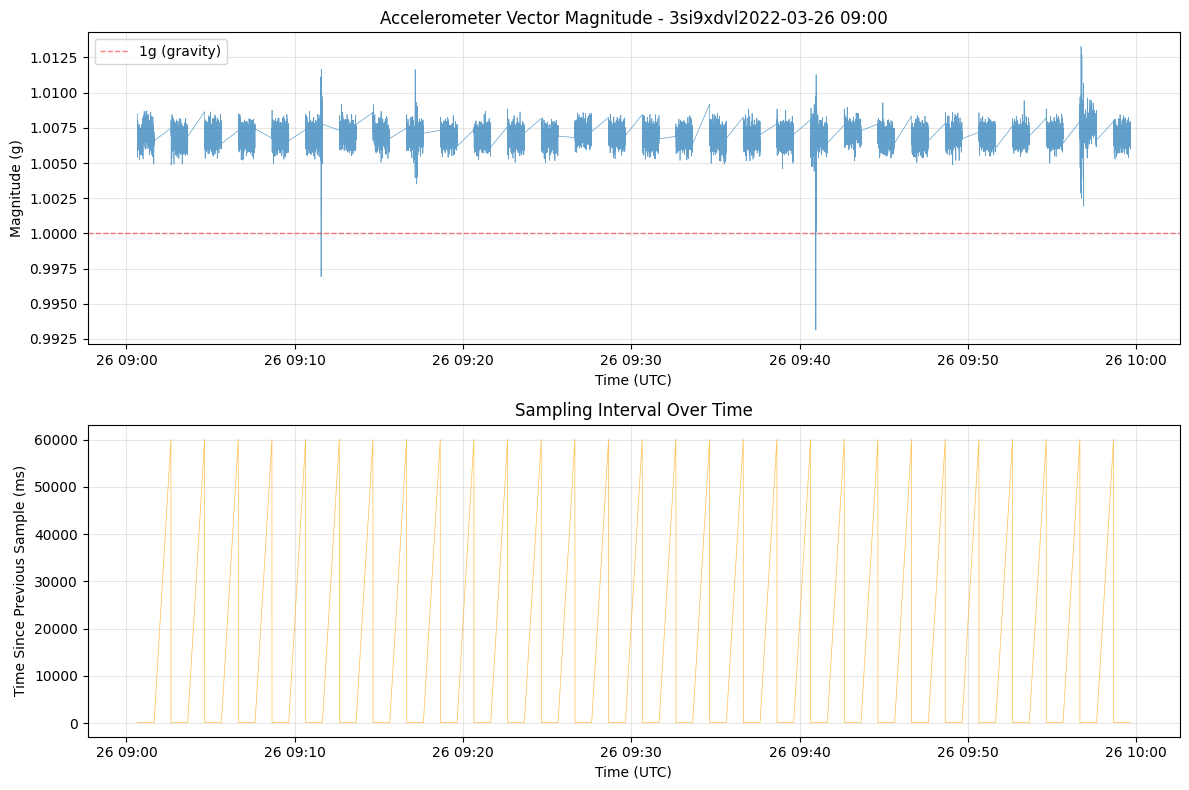

In [ ]:
# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# --- Magnitude over time ---
axes[0].plot(test_df['datetime_utc'], test_df['magnitude'], linewidth=0.5, alpha=0.7)
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='1g (gravity)')
axes[0].set_xlabel('Time (UTC)')
axes[0].set_ylabel('Magnitude (g)')
axes[0].set_title('Accelerometer Vector Magnitude - 3si9xdvl2022-03-26 09:00')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Sampling intervals ---
axes[1].plot(test_df['datetime_utc'].iloc[1:], test_df['time_diff_ms'].iloc[1:], 
             linewidth=0.5, alpha=0.7, color='orange')
axes[1].set_xlabel('Time (UTC)')
axes[1].set_ylabel('Time Since Previous Sample (ms)')
axes[1].set_title('Sampling Interval Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Identify gaps (where gap refers to interval > 1000ms = 1 second)
gaps = test_df['time_diff_ms'] > 1000

print("\n=== Burst Patterns ===")
print(f"Number of gaps (>1 sec): {gaps.sum()}")
print(f"Number of bursts: {gaps.sum() + 1}")

# Find gap locations and durations
gap_info = test_df[gaps][['datetime_utc', 'time_diff_ms']]
print(f"\nGap durations:")
print(gap_info['time_diff_ms'].describe())

# Calculate burst durations (time between gaps)
burst_starts = test_df[gaps].index.tolist()
burst_starts.insert(0, 0)  # Add start of file

print(f"\nBurst sizes (number of samples per burst):")
burst_sizes = []
for i in range(len(burst_starts) - 1):
    burst_size = burst_starts[i+1] - burst_starts[i]
    burst_sizes.append(burst_size)

burst_sizes = np.array(burst_sizes)
print(f"Min:    {burst_sizes.min()} samples")
print(f"Max:    {burst_sizes.max()} samples")
print(f"Med: {np.median(burst_sizes):.0f} samples")
print(f"Mean:   {burst_sizes.mean():.1f} samples")

# length of each burst
print(f"\nBurst durations (at 10 Hz):")
print(f"Med: {np.median(burst_sizes) / 10:.1f} seconds")


=== Burst Patterns ===
Number of gaps (>1 sec): 29
Number of bursts: 30

Gap durations:
count       29.000000
mean     60071.620690
std         20.829947
min      60014.000000
25%      60068.000000
50%      60072.000000
75%      60076.000000
max      60132.000000
Name: time_diff_ms, dtype: float64

Burst sizes (number of samples per burst):
Min:    603 samples
Max:    603 samples
Med: 603 samples
Mean:   603.0 samples

Burst durations (at 10 Hz):
Med: 60.3 seconds


In [36]:
# Now want to examine files with significantly fewer number of rows than expected 

# Convert timestamps
hr_16_df['datetime_utc'] = pd.to_datetime(hr_16_df['timestamp'], unit='ms', utc=True)

print("=== 16:00 file sampling pattern ===")
print(f"Number of rows: {len(hr_16_df)}")
print(f"First timestamp: {hr_16_df['datetime_utc'].iloc[0]}")
print(f"Last timestamp:  {hr_16_df['datetime_utc'].iloc[-1]}")

# Calculate time span
time_span = hr_16_df['datetime_utc'].iloc[-1] - hr_16_df['datetime_utc'].iloc[0]
print(f"Time span: {time_span}")

# Calculate sampling time
sampling_time_min = len(hr_16_df) / 10 / 60
print(f"\nSampling time: {sampling_time_min:.1f} minutes")

# Calculate duty cycle
walltime_min = time_span.total_seconds() / 60
duty_cycle = sampling_time_min / walltime_min
print(f"Wall clock time: {walltime_min:.1f} minutes")
print(f"Duty cycle: {duty_cycle:.1%}")

# Check burst pattern
hr_16_df['time_diff_ms'] = hr_16_df['timestamp'].diff()
gaps_16 = hr_16_df['time_diff_ms'] > 1000
print(f"\nNumber of bursts: {gaps_16.sum() + 1}")

=== 16:00 file sampling pattern ===
Number of rows: 9049
First timestamp: 2022-03-26 16:30:01.212000+00:00
Last timestamp:  2022-03-26 16:59:02.238000+00:00
Time span: 0 days 00:29:01.026000

Sampling time: 15.1 minutes
Wall clock time: 29.0 minutes
Duty cycle: 52.0%

Number of bursts: 15
